In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from helpers.cm26 import DatasetCM26, read_datasets
from helpers.selectors import select_NA, select_Pacific, select_Cem, select_globe, compare, plot, select_ACC, select_Equator
from helpers.operators import Coarsen, Filtering, Subsampling, CoarsenKochkov, CoarsenWeighted, CoarsenKochkovMinMax
from helpers.state_functions import *

import hvplot.xarray
import hvplot
import cmocean

import matplotlib as mpl

%load_ext autoreload
%autoreload 3

In [2]:
def read_skill(exp='EXP0', factors=[4,9,12,15]):
    ds = {}
    for factor in factors:
        data = xr.open_dataset(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/{exp}/skill-test/factor-{factor}.nc', chunks={'zl':1})
        data['zl'] = -data['zl']
        ds[factor] = data
        
    return ds

In [3]:
def backscatter_ratio(transfer, freq_str):
    transfer_noncompensated = transfer / transfer[freq_str]
    transfer_plus = np.maximum(transfer_noncompensated,0.0)
    transfer_minus =  np.minimum(transfer_noncompensated,0.0)
    return -transfer_plus.sum(freq_str) / transfer_minus.sum(freq_str)

In [48]:
def plot_transfer(transfer, freq_str='freq_r_NA', zl=0, color='tab:blue'):
    mean = transfer.mean('time').isel(zl=zl)
    std = transfer.std('time').isel(zl=zl)
    
    mean.plot(xscale='log',color=color,lw=2)
    plt.fill_between(mean[freq_str],mean-std,mean+std,alpha=0.05,color=color, linewidth=0)
    return backscatter_ratio(mean,freq_str)

# Transfer spectrum and deformation radius

In [5]:
ds = read_datasets(['validate'], [4])

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-4


In [6]:
def select(x, region):
    if region == 'NA':
        kw = {'Lat': (25,45), 'Lon': (-60,-40)}
    elif region == 'Pacific':
        kw = {'Lat': (25,45), 'Lon': (-200,-180)}
    elif region == 'Equator':
        kw = {'Lat': (-30,30), 'Lon': (-190,-130)}
    elif region == 'ACC':
        kw = {'Lat': (-70,-30), 'Lon': (-40,0)}
    else:
        print('Error: wrong region')
    return select_LatLon(x,time=slice(None,None),**kw)

In [7]:
Ld = ds['validate-4'].data.deformation_radius/1e+3

In [8]:
for region in ['NA', 'Pacific', 'ACC', 'Equator']:
    print(region, float(select(Ld, region).mean()))

NA 22.61805534362793
Pacific 28.477930068969727
ACC 10.45057487487793
Equator 88.92626190185547


In [75]:
def plot_transfer_4_regions(exps=[],zl=5,factor=4,labels=[]):
    plt.figure(figsize=(10,8))
    plt.rcParams['font.size']=12

    colors= ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
    
    plt.subplot(2,2,1)
    ratio = plot_transfer(exps[0][factor].transfer_NA,'freq_r_NA',color='k',zl=zl)
    for exp, color in zip(exps, colors):
        plot_transfer(exp[factor].transfer_ZB_NA,'freq_r_NA',zl=zl,color=color)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('North Atlantic')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.axvline(x=1/(22.6e+3), color='tab:gray', ls='--')
    plt.xlim([1e-6,2e-4])
    plt.text(1e-5, 0, 'Backscat ratio: %.1f' % float(ratio))

    plt.subplot(2,2,2)
    ratio=plot_transfer(exps[0][factor].transfer_Pacific,'freq_r_Pacific',color='k',zl=zl)
    for exp, color in zip(exps,colors):
        plot_transfer(exp[factor].transfer_ZB_Pacific,'freq_r_Pacific',zl=zl,color=color)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('Pacific')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.axvline(x=1/(28.5e+3), color='tab:gray', ls='--')
    plt.xlim([1e-6,2e-4])
    plt.text(1e-5, 0, 'Backscat ratio: %.1f' % float(ratio))
    
    plt.subplot(2,2,3)
    ratio=plot_transfer(exps[0][factor].transfer_ACC,'freq_r_ACC',color='k',zl=zl)
    for exp,color in zip(exps,colors):
        plot_transfer(exp[factor].transfer_ZB_ACC,'freq_r_ACC',zl=zl,color=color)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('ACC')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.axvline(x=1/(10.5e+3), color='tab:gray',ls='--')
    plt.xlim([1e-6,2e-4])
    plt.text(1e-5, 0, 'Backscat ratio: %.1f' % float(ratio))
        
    plt.subplot(2,2,4)
    ratio=plot_transfer(exps[0][factor].transfer_Equator,'freq_r_Equator',color='k',zl=zl)
    for exp,color in zip(exps,colors):
        plot_transfer(exp[factor].transfer_ZB_Equator,'freq_r_Equator',zl=zl,color=color)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('Equator')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.tight_layout()
    plt.axvline(x=1/(89.9e+3), color='tab:gray',ls='--')
    plt.xlim([1e-6,2e-4])
    plt.text(1e-5, 0, 'Backscat ratio: %.1f' % float(ratio))
    
    plt.plot(np.nan,np.nan,color='k',label='SFS')
    for label, color in zip(labels,colors):
        plt.plot(np.nan,np.nan,color=color,label=label)
    plt.plot(np.nan,np.nan,color='gray',ls='--',label='$1/R_d$')
    plt.legend(bbox_to_anchor=(1,1))
    
    plt.suptitle(f'Coarsegraining factor: {factor}, Depth: %.0f m' % (float(-exp[factor].zl[zl])), y=1.03)

In [49]:
exp1 = read_skill('EXP1')
exp5 = read_skill('EXP5')
exp7 = read_skill('EXP7')
exp_stencil = read_skill('EXP1-sensitivity/5x5')
exp_20 = read_skill('EXP1-sensitivity/layers-20')
exp_strain = read_skill('EXP1-sensitivity/strain')

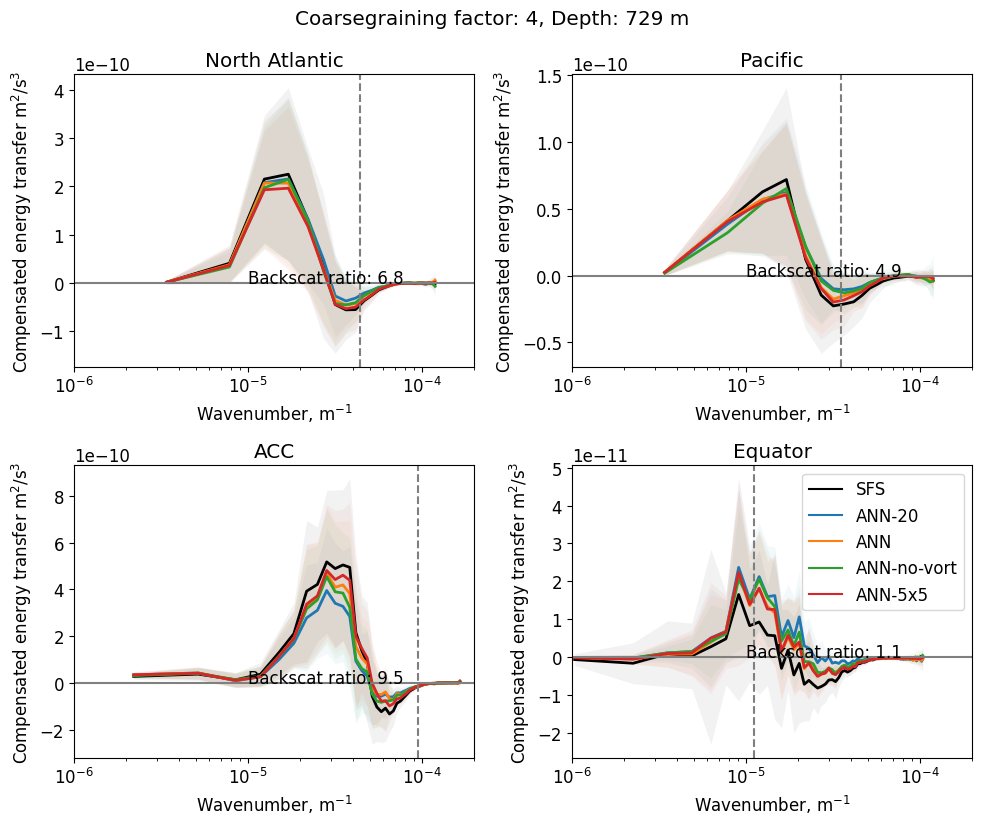

In [69]:
plot_transfer_4_regions([exp_20, exp1, exp_strain, exp_stencil],labels=['ANN-20', 'ANN', 'ANN-no-vort', 'ANN-5x5'])

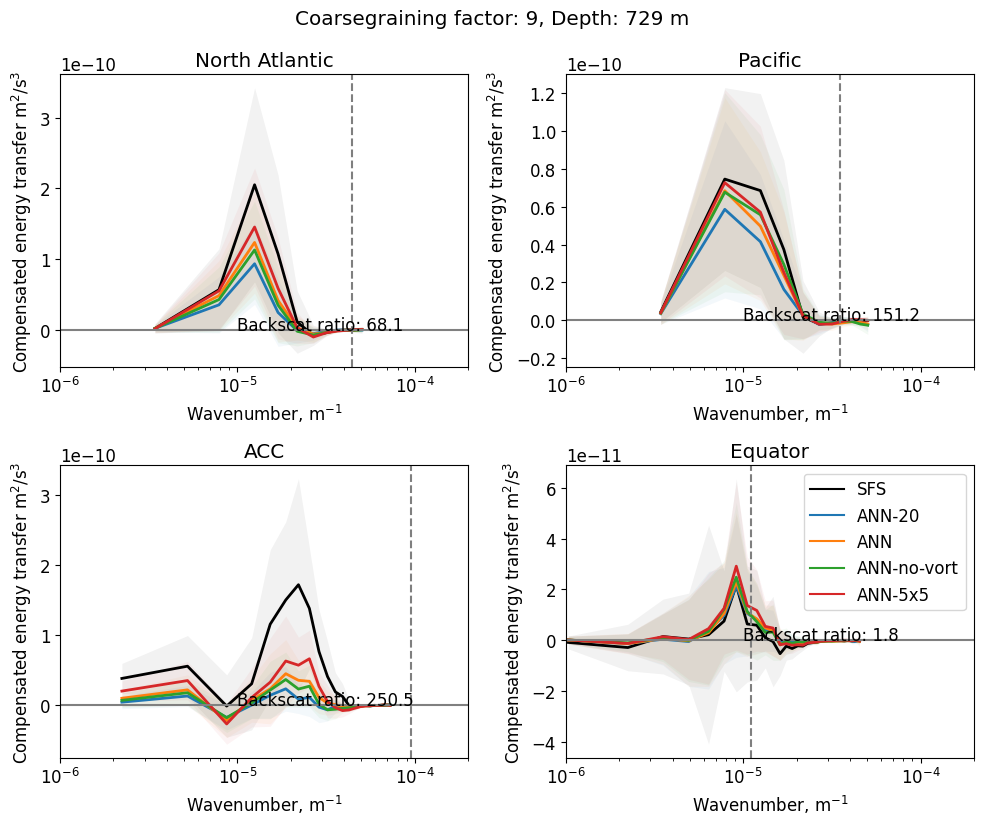

In [70]:
plot_transfer_4_regions([exp_20, exp1, exp_strain, exp_stencil],labels=['ANN-20', 'ANN', 'ANN-no-vort', 'ANN-5x5'], factor=9)

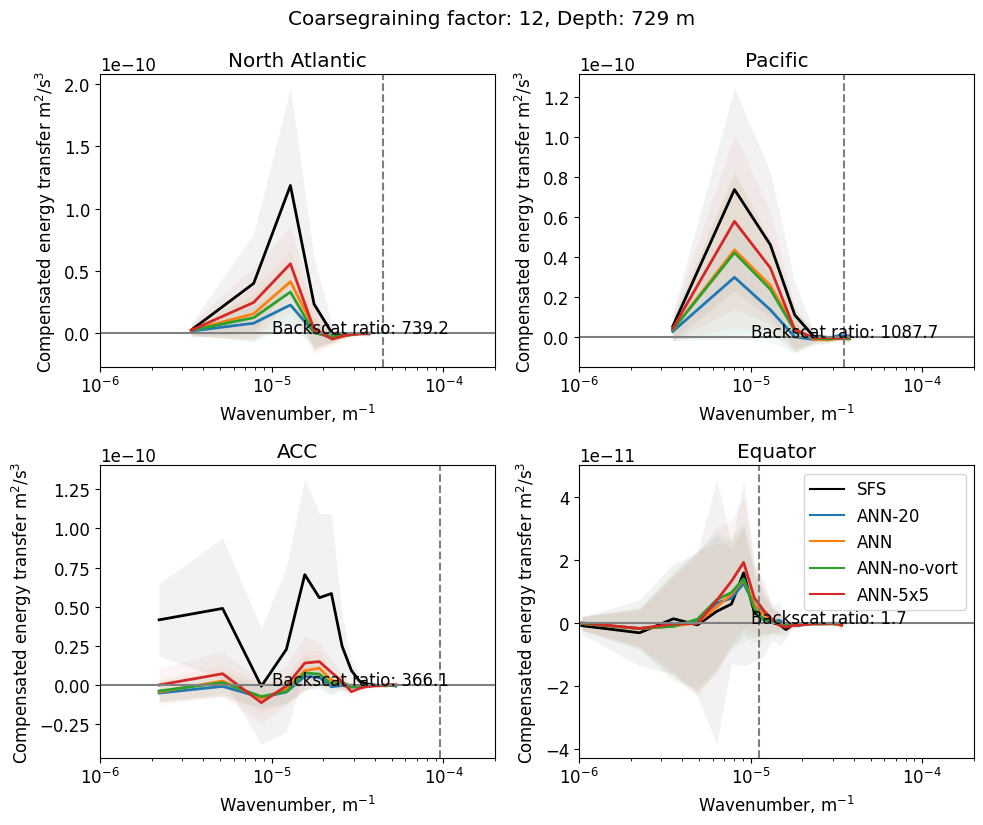

In [71]:
plot_transfer_4_regions([exp_20, exp1, exp_strain, exp_stencil],labels=['ANN-20', 'ANN', 'ANN-no-vort', 'ANN-5x5'], factor=12)

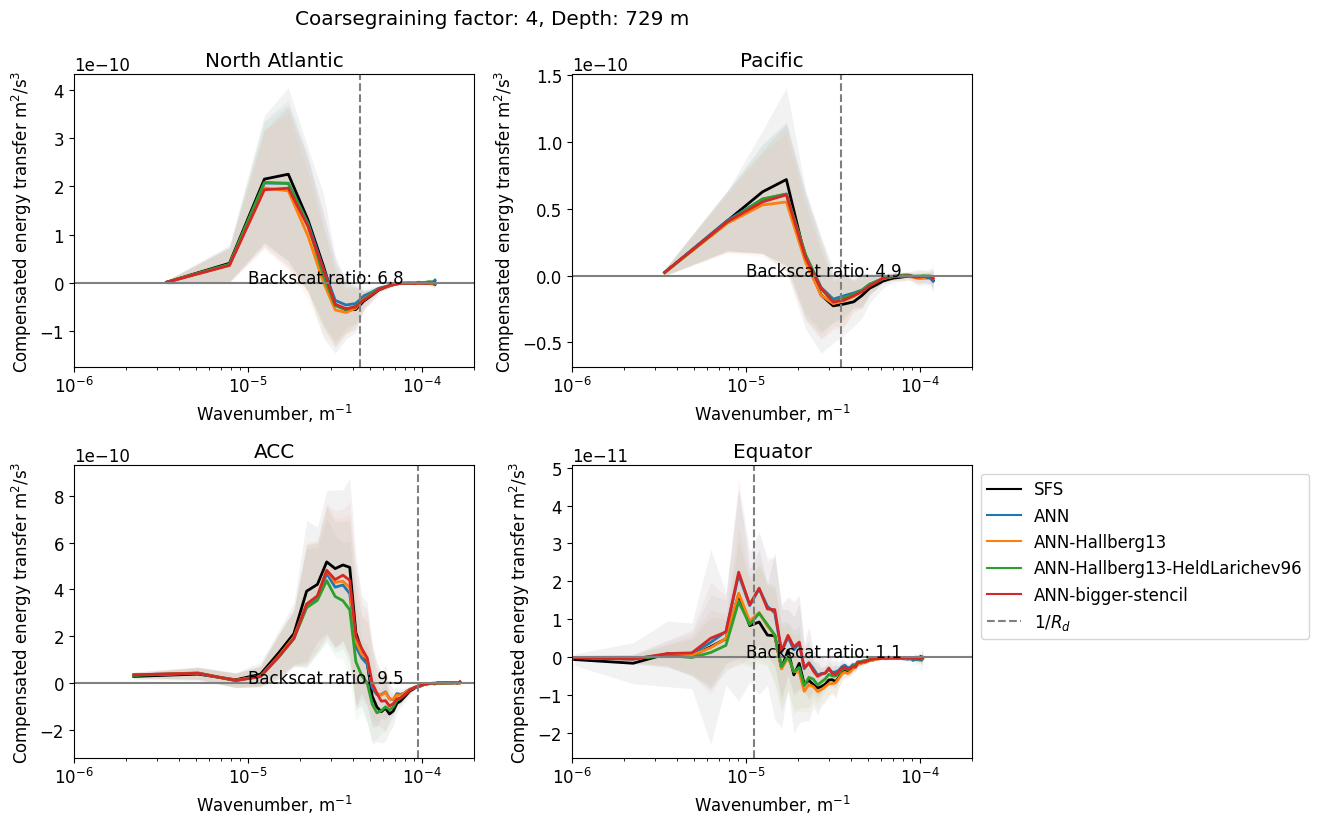

In [76]:
plot_transfer_4_regions([exp1, exp5, exp7, exp_stencil],labels=['ANN', 'ANN-Hallberg13', 'ANN-Hallberg13-HeldLarichev96', 'ANN-bigger-stencil'])
plt.savefig('transfer/factor-4.pdf', bbox_inches='tight')

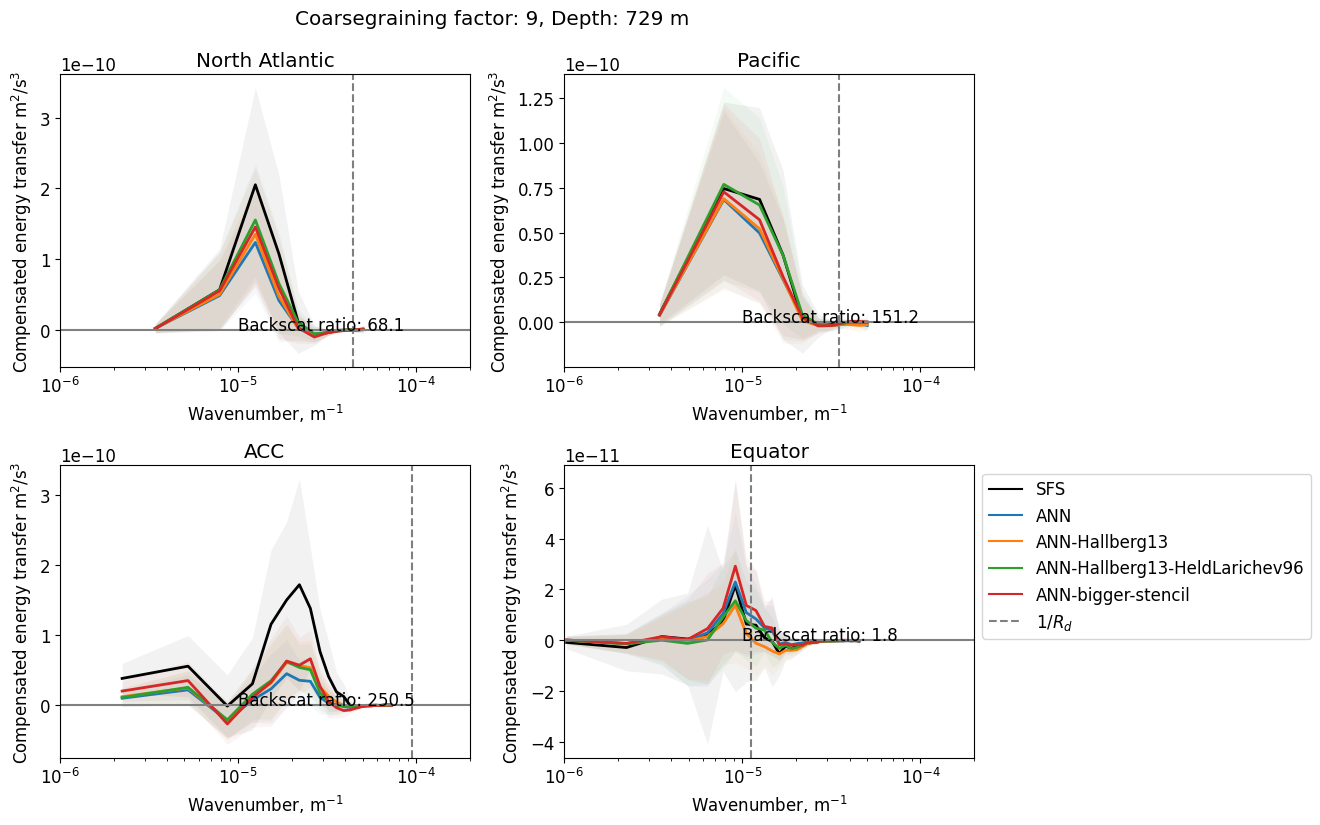

In [77]:
plot_transfer_4_regions([exp1, exp5, exp7, exp_stencil],labels=['ANN', 'ANN-Hallberg13', 'ANN-Hallberg13-HeldLarichev96', 'ANN-bigger-stencil'], factor=9)
plt.savefig('transfer/factor-9.pdf', bbox_inches='tight')

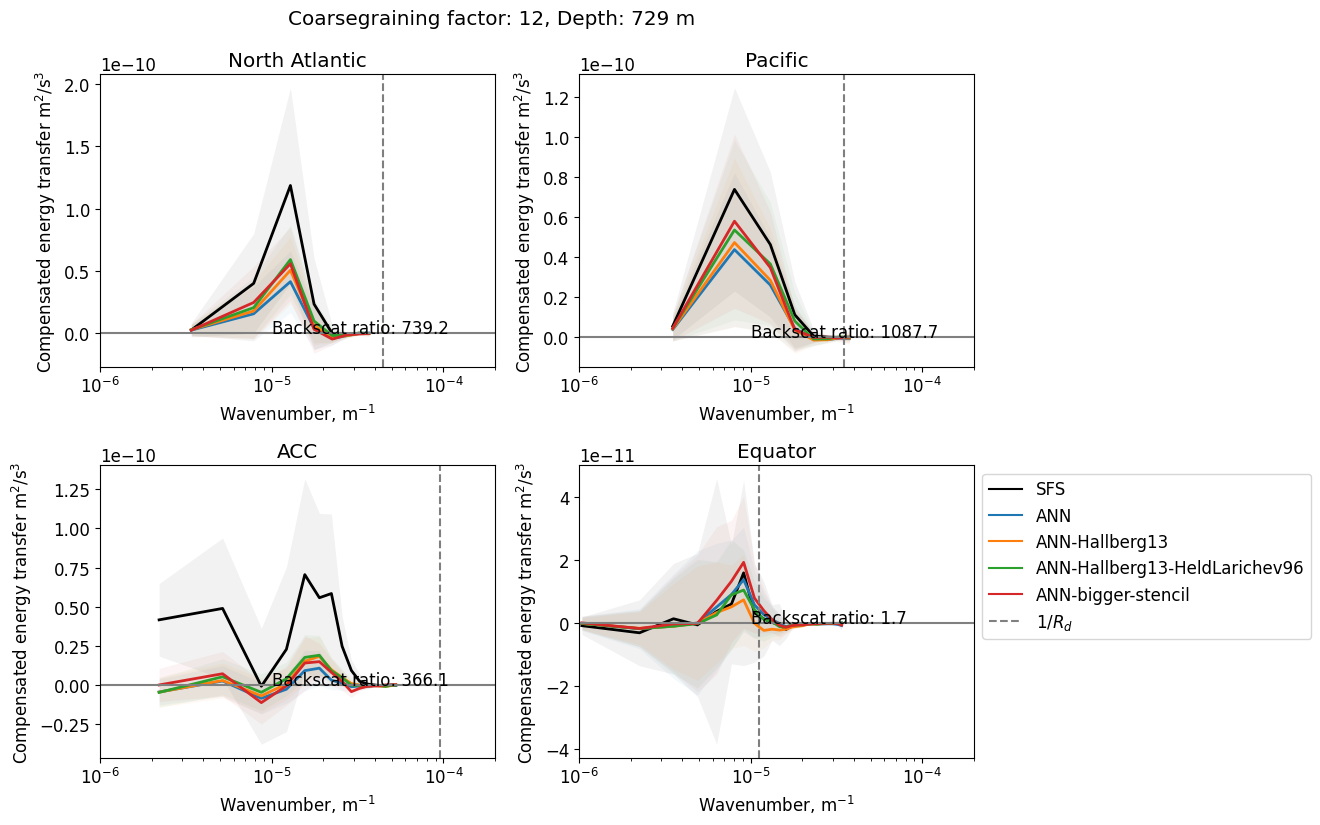

In [78]:
plot_transfer_4_regions([exp1, exp5, exp7, exp_stencil],labels=['ANN', 'ANN-Hallberg13', 'ANN-Hallberg13-HeldLarichev96', 'ANN-bigger-stencil'], factor=12)
plt.savefig('transfer/factor-12.pdf', bbox_inches='tight')

# Can we exclude flux term?

In [99]:
ds = read_datasets(['test'],[12])['test-12']

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12


In [100]:
ZB = ds.state.ZB20()

In [101]:
sp_tendency = ds.state.transfer(ZB['ZB20u'], ZB['ZB20v'],region='Equator')

In [102]:
sp_tensor = ds.state.transfer_tensor(ZB['Txy'], ZB['Txx'], ZB['Tyy'],region='Equator')

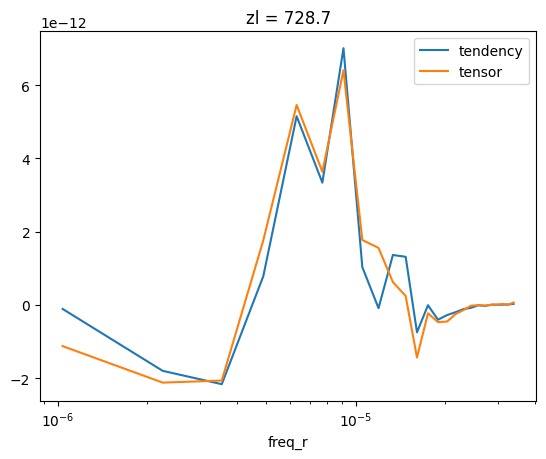

In [103]:
sp_tendency.mean('time').isel(zl=5).plot(xscale='log',label='tendency')
sp_tensor.mean('time').isel(zl=5).plot(xscale='log',label='tensor')
plt.legend()

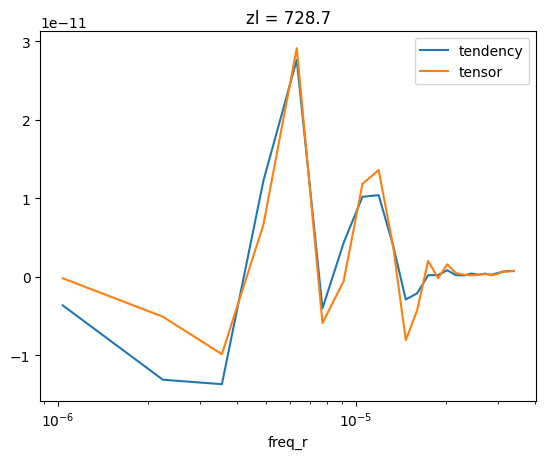

In [104]:
sp_tendency.isel(time=14).isel(zl=5).plot(xscale='log',label='tendency')
sp_tensor.isel(time=14).isel(zl=5).plot(xscale='log',label='tensor')
plt.legend()

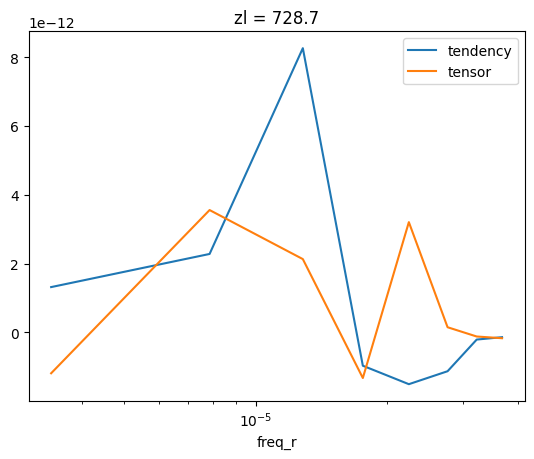

In [105]:
sp_tendency = ds.state.transfer(ZB['ZB20u'], ZB['ZB20v'],region='NA')
sp_tensor = ds.state.transfer_tensor(ZB['Txy'], ZB['Txx'], ZB['Tyy'],region='NA')
sp_tendency.mean('time').isel(zl=5).plot(xscale='log',label='tendency')
sp_tensor.mean('time').isel(zl=5).plot(xscale='log',label='tensor')
plt.legend()

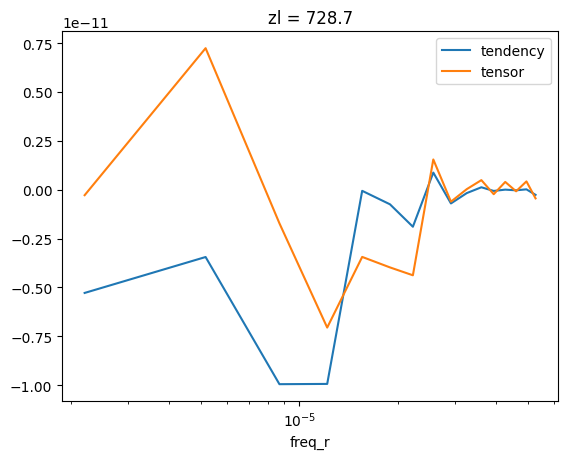

In [106]:
sp_tendency = ds.state.transfer(ZB['ZB20u'], ZB['ZB20v'],region='ACC')
sp_tensor = ds.state.transfer_tensor(ZB['Txy'], ZB['Txx'], ZB['Tyy'],region='ACC')
sp_tendency.mean('time').isel(zl=5).plot(xscale='log',label='tendency')
sp_tensor.mean('time').isel(zl=5).plot(xscale='log',label='tensor')
plt.legend()

In [4]:
from helpers.train_ann import train_ANN

In [5]:
train_ANN()

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Factor: 12, depth: 0, MSE train/validate: [3.453256, 4.102715]
Factor: 15, depth: 0, MSE train/validate: [2.863824, 2.197914]
Iter/num_iters [1/10]. Iter time/Remaining time in seconds: [2.91/26.2]
Factor: 12, depth: 0, MSE train/validate: [2.961748, 3.819943]
Factor: 15, depth: 0, MSE train/validate: [1.896991, 1.951807]
Iter/num_iters [2/10]. Iter time/Remaining time in seconds: [1.10/16.0]
Factor: 12, depth: 0, MSE train/validate: [2.691635, 3.132952]
Factor: 15, depth: 0, MSE train/validate: [1.917547, 1.940045]
Iter/num_iters [3/10]. Iter time/Remaining time in seconds: [1.05/11.8]
Factor: 12, depth: 0, MSE train/validate: [3.094651, 2.677068]
Factor:

(ANN(
   (layers): Sequential(
     (0): Linear(in_features=27, out_features=20, bias=True)
     (1): Linear(in_features=20, out_features=1, bias=True)
   )
 ),
 ANN(
   (layers): Sequential(
     (0): Linear(in_features=27, out_features=20, bias=True)
     (1): Linear(in_features=20, out_features=2, bias=True)
   )
 ),
 None,
 <xarray.Dataset>
 Dimensions:       (factor: 2, iter: 10, depth: 1)
 Coordinates:
   * factor        (factor) int64 12 15
 Dimensions without coordinates: iter, depth
 Data variables:
     MSE_train     (iter, factor, depth) float64 3.453 2.864 ... 2.616 1.692
     MSE_validate  (iter, factor, depth) float64 4.103 2.198 3.82 ... 2.252 1.782)

In [6]:
train_ANN(symmetries='True')

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Factor: 12, depth: 0, MSE train/validate: [1.563853, 1.737270]
Factor: 15, depth: 0, MSE train/validate: [1.308380, 1.359750]
Iter/num_iters [1/10]. Iter time/Remaining time in seconds: [1.56/14.0]
Factor: 12, depth: 0, MSE train/validate: [1.370169, 2.031051]
Factor: 15, depth: 0, MSE train/validate: [1.089947, 1.375190]
Iter/num_iters [2/10]. Iter time/Remaining time in seconds: [1.34/11.6]
Factor: 12, depth: 0, MSE train/validate: [1.549625, 2.536328]
Factor: 15, depth: 0, MSE train/validate: [1.338816, 1.234830]
Iter/num_iters [3/10]. Iter time/Remaining time in seconds: [1.02/9.1]
Factor: 12, depth: 0, MSE train/validate: [1.350366, 1.322683]
Factor: 

(ANN(
   (layers): Sequential(
     (0): Linear(in_features=27, out_features=20, bias=True)
     (1): Linear(in_features=20, out_features=1, bias=True)
   )
 ),
 ANN(
   (layers): Sequential(
     (0): Linear(in_features=27, out_features=20, bias=True)
     (1): Linear(in_features=20, out_features=2, bias=True)
   )
 ),
 None,
 <xarray.Dataset>
 Dimensions:       (factor: 2, iter: 10, depth: 1)
 Coordinates:
   * factor        (factor) int64 12 15
 Dimensions without coordinates: iter, depth
 Data variables:
     MSE_train     (iter, factor, depth) float64 1.564 1.308 1.37 ... 1.041 1.117
     MSE_validate  (iter, factor, depth) float64 1.737 1.36 2.031 ... 1.21 1.165)

In [9]:
train_ANN(symmetries='All', time_iters=30)

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Factor: 12, depth: 0, MSE train/validate: [2.820909, 1.865760]
Factor: 15, depth: 0, MSE train/validate: [1.279297, 1.445069]
Iter/num_iters [1/30]. Iter time/Remaining time in seconds: [1.52/43.9]
Factor: 12, depth: 0, MSE train/validate: [1.355434, 1.933373]
Factor: 15, depth: 0, MSE train/validate: [1.244288, 1.118904]
Iter/num_iters [2/30]. Iter time/Remaining time in seconds: [1.31/39.6]
Factor: 12, depth: 0, MSE train/validate: [1.760512, 1.148055]
Factor: 15, depth: 0, MSE train/validate: [1.165826, 1.103397]
Iter/num_iters [3/30]. Iter time/Remaining time in seconds: [1.51/39.0]
Factor: 12, depth: 0, MSE train/validate: [1.118872, 1.041628]
Factor:

(ANN(
   (layers): Sequential(
     (0): Linear(in_features=27, out_features=20, bias=True)
     (1): Linear(in_features=20, out_features=1, bias=True)
   )
 ),
 ANN(
   (layers): Sequential(
     (0): Linear(in_features=27, out_features=20, bias=True)
     (1): Linear(in_features=20, out_features=2, bias=True)
   )
 ),
 None,
 <xarray.Dataset>
 Dimensions:       (factor: 2, iter: 30, depth: 1)
 Coordinates:
   * factor        (factor) int64 12 15
 Dimensions without coordinates: iter, depth
 Data variables:
     MSE_train     (iter, factor, depth) float64 2.821 1.279 ... 0.8229 0.903
     MSE_validate  (iter, factor, depth) float64 1.866 1.445 ... 0.7849 0.8868)

In [10]:
train_ANN(symmetries='False', time_iters=30)

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Factor: 12, depth: 0, MSE train/validate: [3.536606, 5.428726]
Factor: 15, depth: 0, MSE train/validate: [3.210747, 2.934203]
Iter/num_iters [1/30]. Iter time/Remaining time in seconds: [1.66/48.1]
Factor: 12, depth: 0, MSE train/validate: [3.100782, 3.117308]
Factor: 15, depth: 0, MSE train/validate: [4.091917, 2.711292]
Iter/num_iters [2/30]. Iter time/Remaining time in seconds: [0.99/37.1]
Factor: 12, depth: 0, MSE train/validate: [3.123344, 4.232466]
Factor: 15, depth: 0, MSE train/validate: [2.768686, 2.568769]
Iter/num_iters [3/30]. Iter time/Remaining time in seconds: [1.06/33.4]
Factor: 12, depth: 0, MSE train/validate: [3.240801, 5.494991]
Factor:

(ANN(
   (layers): Sequential(
     (0): Linear(in_features=27, out_features=20, bias=True)
     (1): Linear(in_features=20, out_features=1, bias=True)
   )
 ),
 ANN(
   (layers): Sequential(
     (0): Linear(in_features=27, out_features=20, bias=True)
     (1): Linear(in_features=20, out_features=2, bias=True)
   )
 ),
 None,
 <xarray.Dataset>
 Dimensions:       (factor: 2, iter: 30, depth: 1)
 Coordinates:
   * factor        (factor) int64 12 15
 Dimensions without coordinates: iter, depth
 Data variables:
     MSE_train     (iter, factor, depth) float64 3.537 3.211 ... 2.163 1.266
     MSE_validate  (iter, factor, depth) float64 5.429 2.934 ... 1.632 1.358)

In [11]:
train_ANN(symmetries='None', time_iters=30)

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Factor: 12, depth: 0, MSE train/validate: [1.625126, 1.894320]
Factor: 15, depth: 0, MSE train/validate: [1.569300, 1.449352]
Iter/num_iters [1/30]. Iter time/Remaining time in seconds: [1.79/52.0]
Factor: 12, depth: 0, MSE train/validate: [1.233155, 1.387784]
Factor: 15, depth: 0, MSE train/validate: [1.134876, 1.118394]
Iter/num_iters [2/30]. Iter time/Remaining time in seconds: [1.55/46.8]
Factor: 12, depth: 0, MSE train/validate: [1.113926, 1.049801]
Factor: 15, depth: 0, MSE train/validate: [1.008933, 1.011708]
Iter/num_iters [3/30]. Iter time/Remaining time in seconds: [1.32/42.0]
Factor: 12, depth: 0, MSE train/validate: [0.959180, 0.970386]
Factor:

(ANN(
   (layers): Sequential(
     (0): Linear(in_features=27, out_features=20, bias=True)
     (1): Linear(in_features=20, out_features=1, bias=True)
   )
 ),
 ANN(
   (layers): Sequential(
     (0): Linear(in_features=27, out_features=20, bias=True)
     (1): Linear(in_features=20, out_features=2, bias=True)
   )
 ),
 None,
 <xarray.Dataset>
 Dimensions:       (factor: 2, iter: 30, depth: 1)
 Coordinates:
   * factor        (factor) int64 12 15
 Dimensions without coordinates: iter, depth
 Data variables:
     MSE_train     (iter, factor, depth) float64 1.625 1.569 ... 0.7654 0.8252
     MSE_validate  (iter, factor, depth) float64 1.894 1.449 ... 0.7482 0.8024)